In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import networkx as nx

In [ ]:
# data cleaning and preprocessing

import pandas as pd

# Load the dataset
df = pd.read_csv('./nainital_forest.csv')

# 1. Check for missing values
print("Missing values:\n", df.isnull().sum())

# 2. Remove rows with missing values
data_cleaned = df.dropna()

# 3. Check for duplicates
print(f"Duplicate rows: {data_cleaned.duplicated().sum()}")

# Remove duplicates if found
data_cleaned = data_cleaned.drop_duplicates()

# 4. Handle outliers (for example, limit the area field)
# Removing extreme outliers in 'area' (burnt area > 90th percentile)
area_threshold = data_cleaned['area'].quantile(0.95)
data_cleaned = data_cleaned[data_cleaned['area'] <= area_threshold]

# 5. Display the cleaned data summary
print(data_cleaned.describe())

Missing values:
 X                0
Y                0
month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
area_category    0
dtype: int64
Duplicate rows: 17
                X           Y        FFMC         DMC          DC         ISI  \
count  347.000000  347.000000  347.000000  347.000000  347.000000  347.000000   
mean     4.528420    4.234339   90.459825  109.003266  527.117181    9.045319   
std      2.225156    1.221348    6.246829   66.928026  263.476648    4.825270   
min      0.929713    1.959931   18.862911    0.469851    9.126571    0.146790   
25%      2.966157    3.971411   90.263344   51.330760  377.216823    6.414069   
50%      4.017108    4.006855   91.600000  107.267878  656.238503    8.343582   
75%      6.052805    5.000000   92.900000  142.674503  707.928407   11.000000   
max      9.054810    9.031966   96.28

In [ ]:
# correlation matrix calculation

# Load the cleaned dataset
df = pd.read_csv('/content/new_similar_dataset.csv')

# Encode categorical variables (month, day) as integers for correlation matrix calculation
df['month'] = df['month'].astype('category').cat.codes
df['day'] = df['day'].astype('category').cat.codes

# Strip whitespace from column names to avoid issues
df.columns = df.columns.str.strip()

# Check the columns to ensure there are no leading/trailing spaces
print(df.columns)

# Ensure correct data types
# coerce means that if a column is not of the correct type, it will be set to NaN
df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
df['RH'] = pd.to_numeric(df['RH'], errors='coerce')
df['wind'] = pd.to_numeric(df['wind'], errors='coerce')
df['rain'] = pd.to_numeric(df['rain'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['day'] = pd.to_numeric(df['day'], errors='coerce')
df['area'] = pd.to_numeric(df['area'], errors='coerce')

# Calculate covariance matrix
# covariance matrix is a matrix in which the element in the i, j position is the covariance between the i-th and j-th elements of a random vector.
cov_matrix = df[['temp', 'RH', 'wind', 'rain', 'month', 'day', 'area']].cov()

print("Covariance matrix:")
print(cov_matrix)

Index(['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH',
       'wind', 'rain', 'area', 'area_category'],
      dtype='object')
Covariance matrix:
            temp          RH      wind      rain      month       day  \
temp   34.490279  -57.550658 -1.516109  0.008627  -1.538770  1.824778   
RH    -57.550658  288.987706  3.617721  0.234412 -10.092850 -3.465245   
wind   -1.516109    3.617721  3.176085  0.014914  -1.174935 -0.139948   
rain    0.008627    0.234412  0.014914  0.006533  -0.036940  0.013082   
month  -1.538770  -10.092850 -1.174935 -0.036940  18.886949 -1.341633   
day     1.824778   -3.465245 -0.139948  0.013082  -1.341633  3.679439   
area   63.117491 -111.618345  5.361051 -0.096749   6.738440  3.448888   

              area  
temp     63.117491  
RH     -111.618345  
wind      5.361051  
rain     -0.096749  
month     6.738440  
day       3.448888  
area   4962.034358  


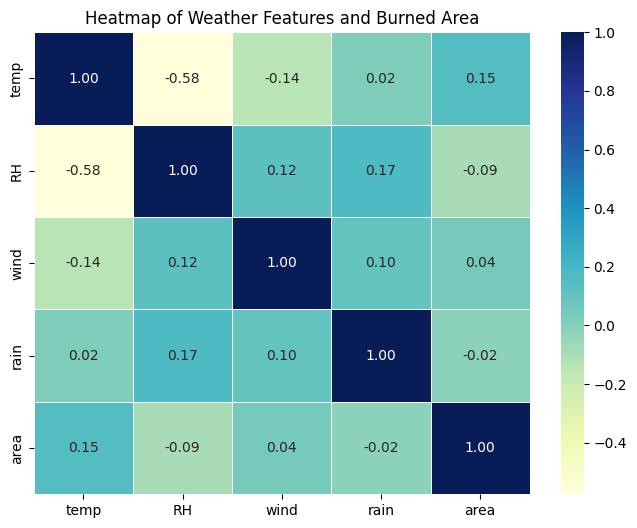

In [ ]:
# Heatmap of selected features and target variable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset

# Select relevant features
selected_features = ['temp', 'RH', 'wind', 'rain', 'area']

# Compute the correlation matrix
correlation_matrix = df[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu", fmt='.2f', linewidths=0.5)
plt.title("Heatmap of Weather Features and Burned Area")
plt.show()

In [ ]:
# Define a custom dataset class for the data
class ForestFireDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        features = torch.tensor([sample['temp'], sample['RH'], sample['wind'], sample['rain'], sample['month'], sample['day']], dtype=torch.float32)
        target = torch.tensor([sample['area']], dtype=torch.float32)
        return features, target

In [ ]:
#  the dataset and data loaders
dataset = ForestFireDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
#  neural network model
class ForestFireModel(nn.Module):
    def __init__(self):
        super(ForestFireModel, self).__init__()
        self.fc1 = nn.Linear(6, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Initialize the models, loss functions, and optimizers
nn_model = ForestFireModel()
nn_criterion = nn.MSELoss()
nn_optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

svm_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1)
)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
lr_model = LinearRegression()

In [ ]:
# Train the models
for epoch in range(100):
    for features, target in data_loader:
        nn_optimizer.zero_grad()
        nn_output = nn_model(features)
        nn_loss = nn_criterion(nn_output, target)
        nn_loss.backward()
        nn_optimizer.step()
    print(f'Epoch {epoch+1}, NN Loss: {nn_loss.item()}')

Epoch 1, NN Loss: 18164.5546875
Epoch 2, NN Loss: 239.19747924804688
Epoch 3, NN Loss: 83.05038452148438
Epoch 4, NN Loss: 370.12969970703125
Epoch 5, NN Loss: 17777.154296875
Epoch 6, NN Loss: 112.34251403808594
Epoch 7, NN Loss: 38260.3203125
Epoch 8, NN Loss: 99.63643646240234
Epoch 9, NN Loss: 1116.4085693359375
Epoch 10, NN Loss: 946.176025390625
Epoch 11, NN Loss: 49.54233932495117
Epoch 12, NN Loss: 49.262882232666016
Epoch 13, NN Loss: 141.53921508789062
Epoch 14, NN Loss: 1125.2086181640625
Epoch 15, NN Loss: 37525.21484375
Epoch 16, NN Loss: 753.9434204101562
Epoch 17, NN Loss: 63.01592254638672
Epoch 18, NN Loss: 97.02333068847656
Epoch 19, NN Loss: 1221.06640625
Epoch 20, NN Loss: 789.50634765625
Epoch 21, NN Loss: 147.44285583496094
Epoch 22, NN Loss: 440.0098876953125
Epoch 23, NN Loss: 246.00328063964844
Epoch 24, NN Loss: 391.34710693359375
Epoch 25, NN Loss: 139.57342529296875
Epoch 26, NN Loss: 1301.596435546875
Epoch 27, NN Loss: 209.30853271484375
Epoch 28, NN Loss:

In [ ]:
svm_model.fit(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']], dataset.df['area'])
rf_model.fit(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']], dataset.df['area'])
lr_model.fit(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']], dataset.df['area'])

LinearRegression()

In [ ]:
# Evaluate the models
nn_model.eval()
total_nn_loss = 0
nn_predictions = []
with torch.no_grad():
    for features, target in data_loader:
        nn_output = nn_model(features)
        nn_loss = nn_criterion(nn_output, target)
        total_nn_loss += nn_loss.item()
        nn_predictions.extend(nn_output.cpu().numpy().flatten())
mean_nn_loss = total_nn_loss / len(data_loader)
print(f'Mean NN Loss: {mean_nn_loss:.6f}')

svm_predictions = svm_model.predict(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])
rf_predictions = rf_model.predict(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])
lr_predictions = lr_model.predict(dataset.df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])

Mean NN Loss: 4753.268609


In [ ]:
# Calculate the total loss of vegetation for each model
total_loss_vegetation_svm = np.sum(svm_predictions)
print(f'Total Loss of Vegetation (SVM): {total_loss_vegetation_svm:.4f} ha')

total_loss_vegetation_rf = np.sum(rf_predictions)
print(f'Total Loss of Vegetation (Random Forest): {total_loss_vegetation_rf:.4f} ha')

total_loss_vegetation_lr = np.sum(lr_predictions)
print(f'Total Loss of Vegetation (Linear Regression): {total_loss_vegetation_lr:.4f} ha')

# Mean accuracy and distance covered for neural network model
nn_predictions = np.clip(np.array(nn_predictions), 0, np.max(df['area']))
df['area'] = np.clip(df['area'], 0.001, np.max(df['area']))  # Clip area values to avoid division by zero
mean_accuracy = np.mean(np.abs(nn_predictions - df['area']) / (df['area'] + 1e-8))  # Add a small value to avoid division by zero
print(f'Mean Accuracy (Neural Network): {mean_accuracy:.4f}')

distance_covered = np.sum(nn_predictions) * 0.1  # Assuming 0.1 km per ha
print(f'Distance Going to Cover (Neural Network): {distance_covered:.4f} km')

# Calculate total burnt area by models used
total_burnt_by_models = total_loss_vegetation_svm + total_loss_vegetation_rf + total_loss_vegetation_lr + np.sum(nn_predictions)

# Calculate average burnt area per model
average_burnt_by_models = total_burnt_by_models / 4  # Divide by 4 for the number of models used

print(f'Total Burnt Area by Models: {total_burnt_by_models:.2f} ha')
print(f'Average Burnt Area by Models: {average_burnt_by_models:.2f} ha')

Total Loss of Vegetation (SVM): 198.7869 ha
Total Loss of Vegetation (Random Forest): 4069.5727 ha
Total Loss of Vegetation (Linear Regression): 4185.2469 ha
Mean Accuracy (Neural Network): 3896.3441
Distance Going to Cover (Neural Network): 426.3044 km
Total Burnt Area by Models: 12716.65 ha
Average Burnt Area by Models: 3179.16 ha


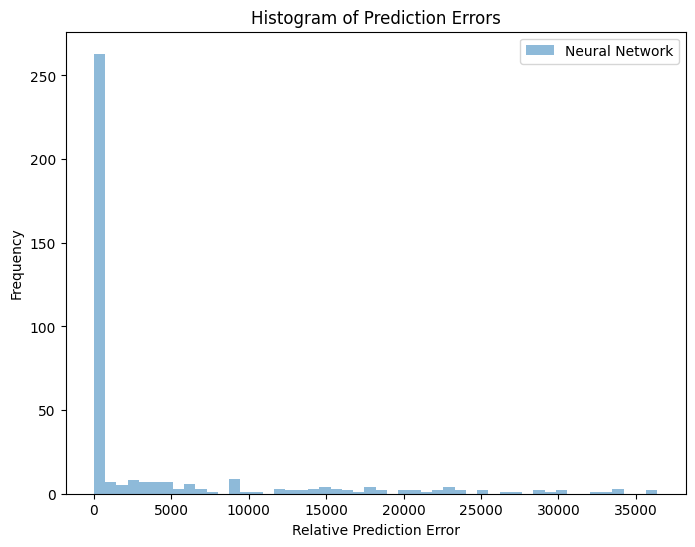

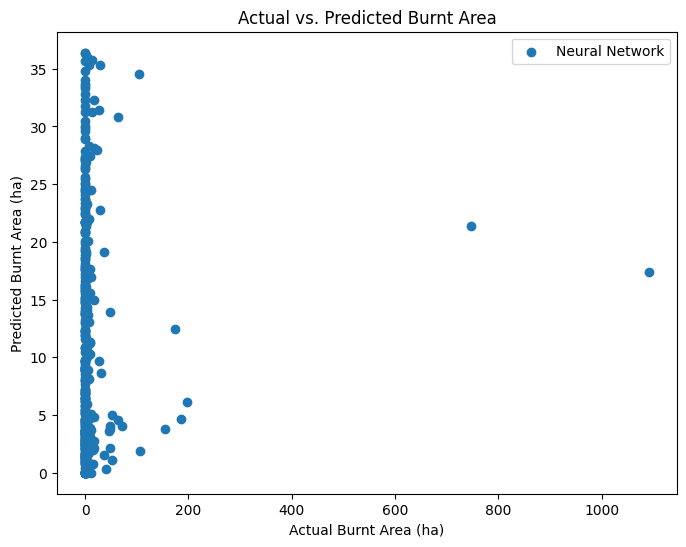

In [ ]:
# Histogram of Prediction Errors
plt.figure(figsize=(8, 6))
plt.hist(np.abs(nn_predictions - df['area']) / df['area'], bins=50, alpha=0.5, label='Neural Network')
plt.xlabel('Relative Prediction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.legend()
plt.show()

# Scatter Plot of Actual vs. Predicted Burnt Area
plt.figure(figsize=(8, 6))
plt.scatter(df['area'], nn_predictions, label='Neural Network')
plt.xlabel('Actual Burnt Area (ha)')
plt.ylabel('Predicted Burnt Area (ha)')
plt.title('Actual vs. Predicted Burnt Area')
plt.legend()
plt.show()

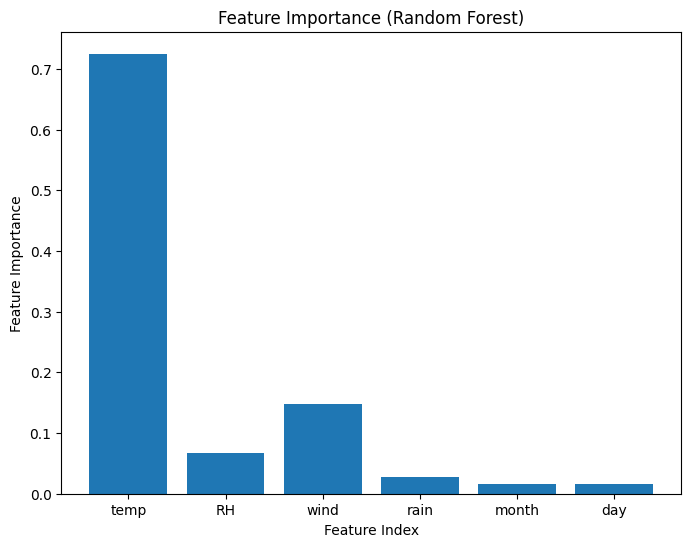

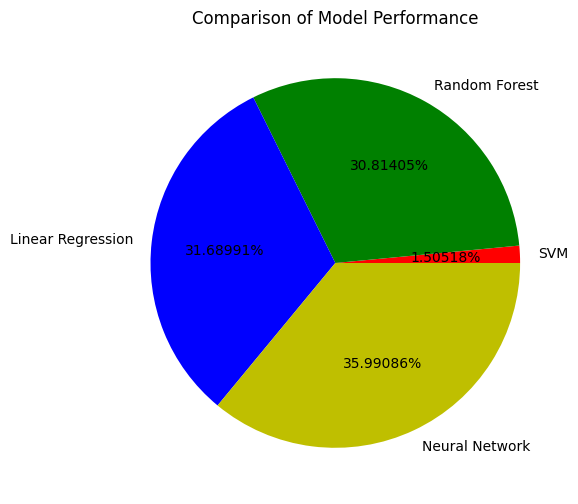

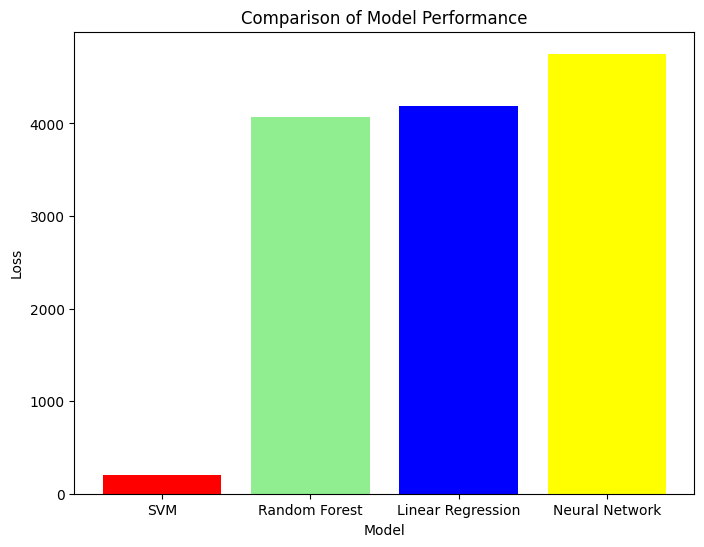

In [ ]:
# Feature Importance Plots for Random Forest Model
# it is a measure of how much a feature contributes to the prediction of the target variable.
importance = rf_model.feature_importances_   #['temp', 'RH', 'wind', 'rain', 'month', 'day']
plt.figure(figsize=(8, 6))
plt.bar(['temp', 'RH', 'wind', 'rain', 'month', 'day'], importance, align='center')
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importance (Random Forest)')
plt.show()

# Pie Chart of Model Performance
plt.figure(figsize=(8, 6))
plt.pie([total_loss_vegetation_svm, total_loss_vegetation_rf, total_loss_vegetation_lr, mean_nn_loss], labels=['SVM', 'Random Forest', 'Linear Regression', 'Neural Network'], colors=['r', 'g', 'b', 'y'], autopct='%1.5f%%')
plt.title('Comparison of Model Performance')
plt.show()

# Comparison of Model Performance
models = ['SVM', 'Random Forest', 'Linear Regression', 'Neural Network']
losses = [total_loss_vegetation_svm, total_loss_vegetation_rf, total_loss_vegetation_lr, mean_nn_loss]
colors = ['red', 'lightgreen', 'blue', 'yellow']
plt.figure(figsize=(8, 6))
plt.bar(models, losses, color=colors, align='center')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Comparison of Model Performance')
plt.show()

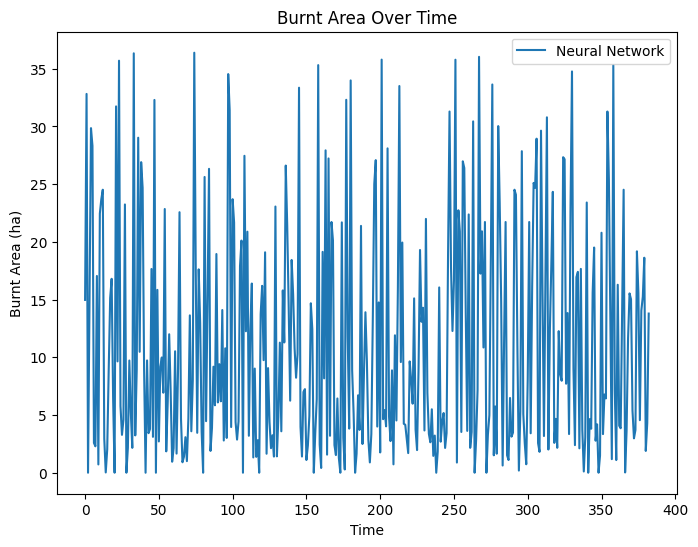

In [ ]:
# Line Chart
plt.figure(figsize=(8, 6))
plt.plot(nn_predictions, label='Neural Network')
plt.xlabel('Time')
plt.ylabel('Burnt Area (ha)')
plt.title('Burnt Area Over Time')
plt.legend()
plt.show()


SVM Confusion Matrix:
TN: 114, FP: 78, FN: 50, TP: 141


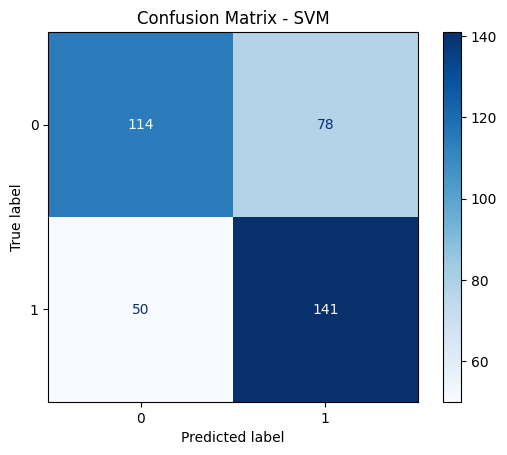

Random Forest Confusion Matrix:
TN: 95, FP: 97, FN: 7, TP: 184


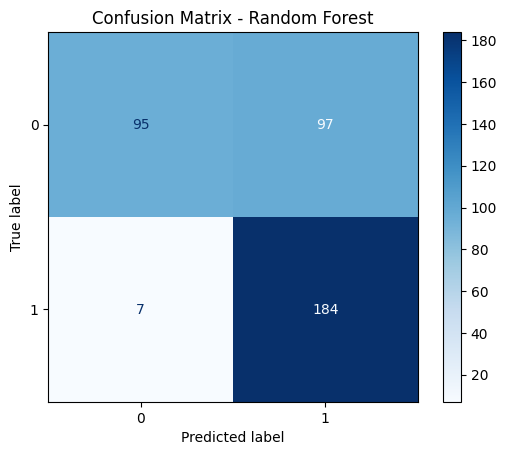

Linear Regression Confusion Matrix:
TN: 37, FP: 155, FN: 29, TP: 162


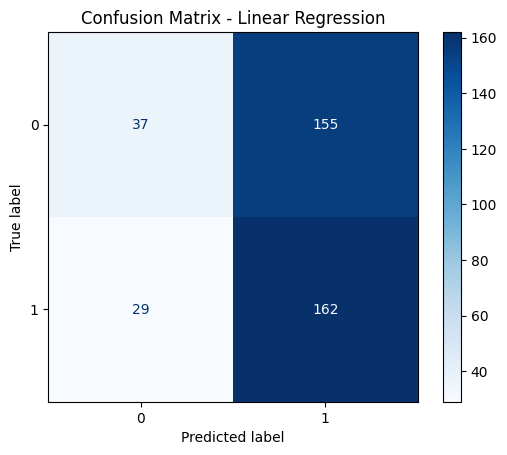

Neural Network Confusion Matrix:
TN: 11, FP: 181, FN: 9, TP: 182


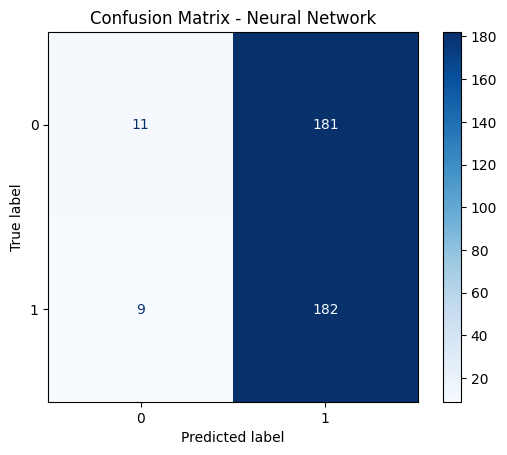

In [ ]:
#prepare confusion matrix for each model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt # Import matplotlib for plotting

# Assuming 'df', 'svm_model', 'rf_model', 'lr_model', 'nn_model', 'data_loader', etc. are defined in previous cells

# Define thresholds for area categories
low_threshold = df['area'].quantile(0.33)
high_threshold = df['area'].quantile(0.66)

# Define a single threshold for binary classification
threshold = df['area'].median()  # Or any other suitable value

# Create a new column with binary labels (0 or 1)
df['area_category'] = (df['area'] > threshold).astype(int)

# Get predictions from each model
svm_predictions = svm_model.predict(df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])  # Assuming these features are in your DataFrame
rf_predictions = rf_model.predict(df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])
lr_predictions = lr_model.predict(df[['temp', 'RH', 'wind', 'rain', 'month', 'day']])

# Get predictions from the Neural Network model
nn_predictions = []
with torch.no_grad():
    for features, target in data_loader:
        nn_output = nn_model(features)
        nn_predictions.extend(nn_output.cpu().numpy().flatten())

# Discretize the predictions for binary classification (0 or 1)

svm_predictions_binary = (svm_predictions > threshold).astype(int)
rf_predictions_binary = (rf_predictions > threshold).astype(int)
lr_predictions_binary = (lr_predictions > threshold).astype(int)

nn_predictions_binary = (np.array(nn_predictions) > threshold).astype(int)  # Convert nn_predictions to NumPy array

# Create and display confusion matrices (2x2)
def display_confusion_matrix(cm, model_name):
    """Displays a 2x2 confusion matrix using matplotlib."""
    TN, FP, FN, TP = cm.ravel()  # Get TN, FP, FN, TP from the confusion matrix
    print(f"{model_name} Confusion Matrix:")
    print(f"TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

svm_cm = confusion_matrix(df['area_category'], svm_predictions_binary)
display_confusion_matrix(svm_cm, "SVM")

rf_cm = confusion_matrix(df['area_category'], rf_predictions_binary)
display_confusion_matrix(rf_cm, "Random Forest")

lr_cm = confusion_matrix(df['area_category'], lr_predictions_binary)
display_confusion_matrix(lr_cm, "Linear Regression")

nn_cm = confusion_matrix(df['area_category'], nn_predictions_binary)
display_confusion_matrix(nn_cm, "Neural Network")

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Function to calculate and display performance metrics
def calculate_performance_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print(f"{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return accuracy, f1, precision, recall

# Calculate metrics for SVM
svm_accuracy, svm_f1, svm_precision, svm_recall = calculate_performance_metrics(df['area_category'], svm_predictions_binary, "SVM")

# Calculate metrics for Random Forest
rf_accuracy, rf_f1, rf_precision, rf_recall = calculate_performance_metrics(df['area_category'], rf_predictions_binary, "Random Forest")

# Calculate metrics for Linear Regression
lr_accuracy, lr_f1, lr_precision, lr_recall = calculate_performance_metrics(df['area_category'], lr_predictions_binary, "Linear Regression")

# Calculate metrics for Neural Network
nn_accuracy, nn_f1, nn_precision, nn_recall = calculate_performance_metrics(df['area_category'], nn_predictions_binary, "Neural Network")

SVM Performance Metrics:
Accuracy: 0.6658
F1 Score: 0.6878
Precision: 0.6438
Recall: 0.7382
Random Forest Performance Metrics:
Accuracy: 0.7285
F1 Score: 0.7797
Precision: 0.6548
Recall: 0.9634
Linear Regression Performance Metrics:
Accuracy: 0.5196
F1 Score: 0.6378
Precision: 0.5110
Recall: 0.8482
Neural Network Performance Metrics:
Accuracy: 0.5039
F1 Score: 0.6570
Precision: 0.5014
Recall: 0.9529


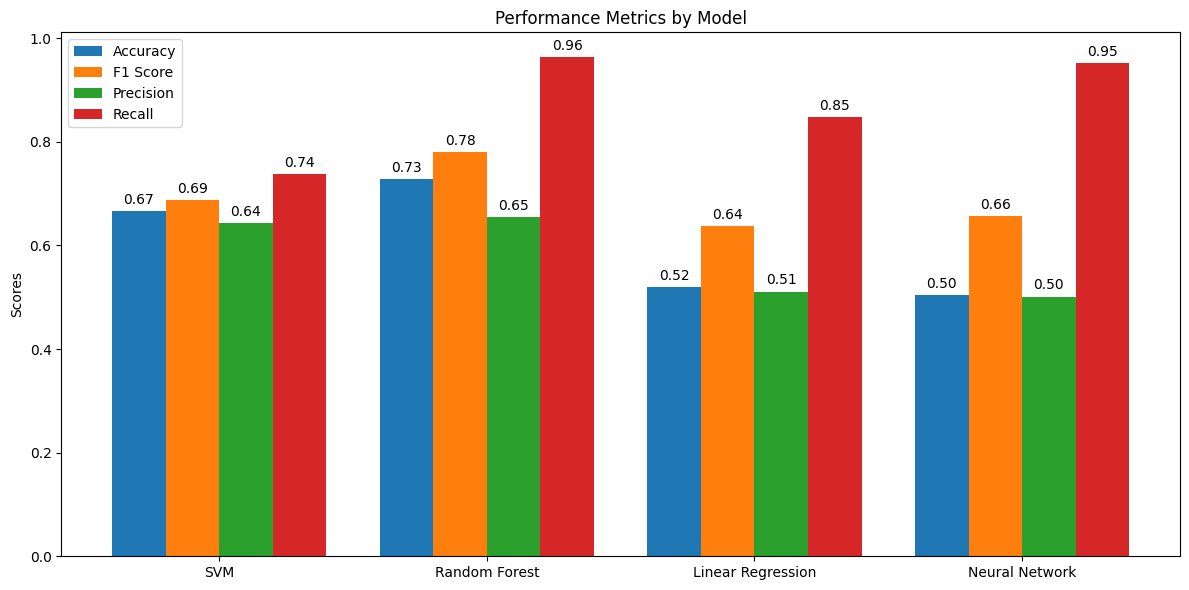

In [ ]:
# Prepare data for plotting
models = ['SVM', 'Random Forest', 'Linear Regression', 'Neural Network']
accuracies = [svm_accuracy, rf_accuracy, lr_accuracy, nn_accuracy]
f1_scores = [svm_f1, rf_f1, lr_f1, nn_f1]
precisions = [svm_precision, rf_precision, lr_precision, nn_precision]
recalls = [svm_recall, rf_recall, lr_recall, nn_recall]

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

# Create a bar plot for each metric
fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(x - width*1.5, accuracies, width, label='Accuracy')
bars2 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
bars3 = ax.bar(x + width/2, precisions, width, label='Precision')
bars4 = ax.bar(x + width*1.5, recalls, width, label='Recall')

# Add some text for labels and title
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add a function to annotate bars with their heights
def add_value_labels(bars):
    """Add labels to bars in a bar chart."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2,
                        height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

plt.tight_layout()
plt.show()

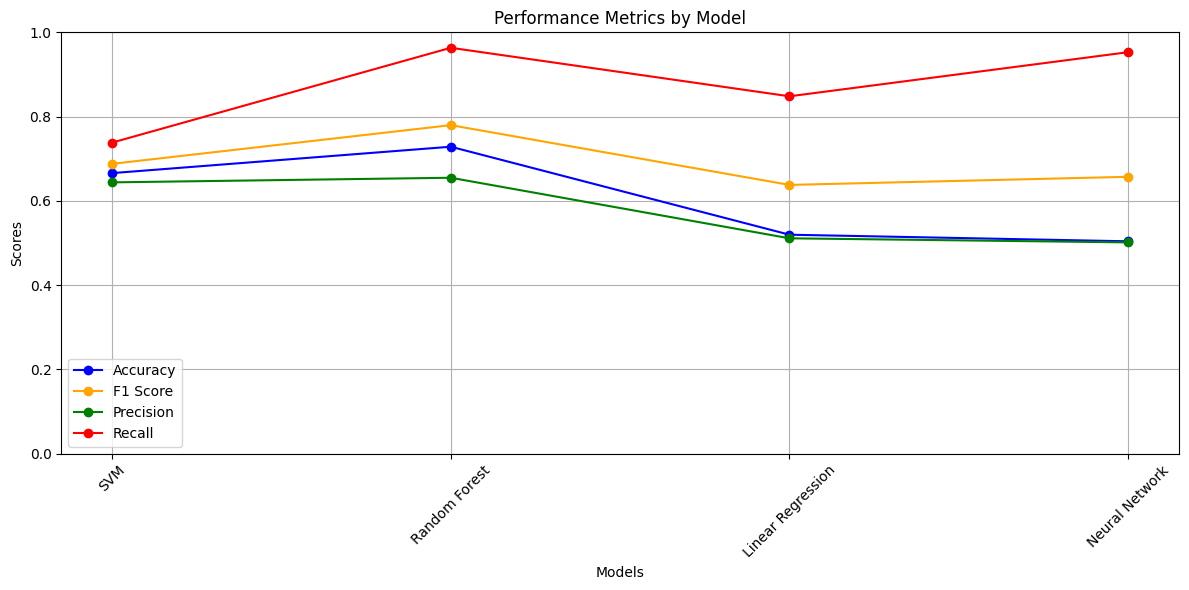

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for plotting
models = ['SVM', 'Random Forest', 'Linear Regression', 'Neural Network']
accuracies = [svm_accuracy, rf_accuracy, lr_accuracy, nn_accuracy]
f1_scores = [svm_f1, rf_f1, lr_f1, nn_f1]
precisions = [svm_precision, rf_precision, lr_precision, nn_precision]
recalls = [svm_recall, rf_recall, lr_recall, nn_recall]

# Create a line plot for each metric
plt.figure(figsize=(12, 6))

# Plotting each metric
plt.plot(models, accuracies, marker='o', label='Accuracy', color='blue')
plt.plot(models, f1_scores, marker='o', label='F1 Score', color='orange')
plt.plot(models, precisions, marker='o', label='Precision', color='green')
plt.plot(models, recalls, marker='o', label='Recall', color='red')

# Adding titles and labels
plt.title('Performance Metrics by Model')
plt.xlabel('Models')
plt.ylabel('Scores')
plt.ylim(0, 1)  # Set y-axis limits to [0, 1] for better visualization
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

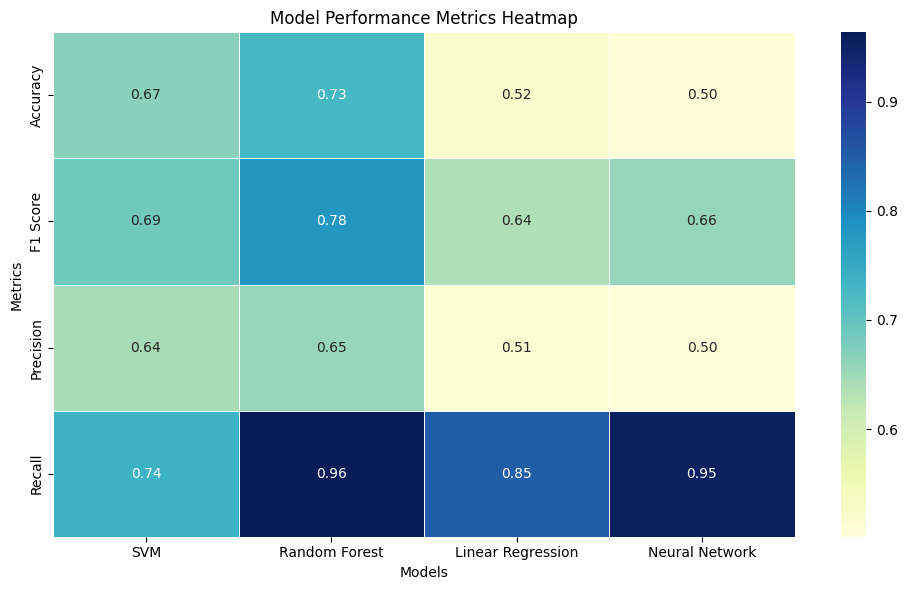

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare performance metrics data
performance_data = {
    'Metrics': ['Accuracy', 'F1 Score', 'Precision', 'Recall'],
    'SVM': [svm_accuracy, svm_f1, svm_precision, svm_recall],
    'Random Forest': [rf_accuracy, rf_f1, rf_precision, rf_recall],
    'Linear Regression': [lr_accuracy, lr_f1, lr_precision, lr_recall],
    'Neural Network': [nn_accuracy, nn_f1, nn_precision, nn_recall]
}

# Create a DataFrame
performance_df = pd.DataFrame(performance_data)

# Set the index to the Metrics column
performance_df.set_index('Metrics', inplace=True)

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.title('Model Performance Metrics Heatmap')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.tight_layout()
plt.show()

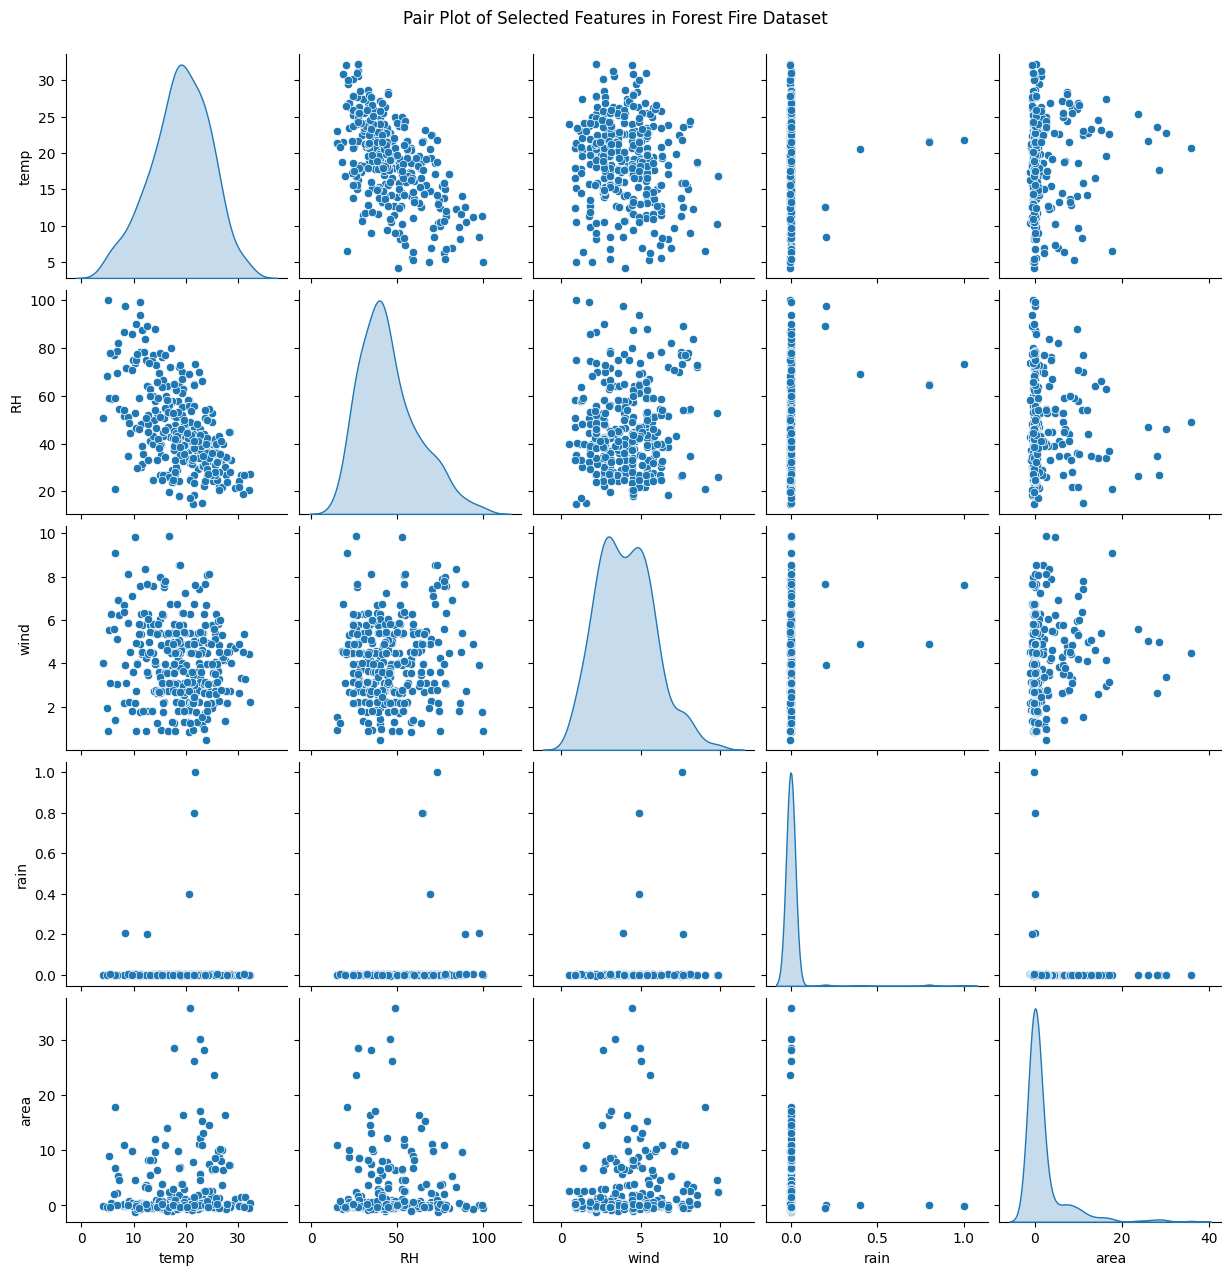

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pair plot for selected features in the cleaned dataset
selected_features = ['temp', 'RH', 'wind', 'rain', 'area']
sns.pairplot(data_cleaned[selected_features], diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features in Forest Fire Dataset', y=1.02)  # Adjust title position
plt.show()